In [79]:
import librosa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
from os.path import join
from scipy import signal
import gc
gc.collect()

44241

### Lectura de datos

In [80]:
path = r'C:\Users\alfon\Desktop\Projects (On Going)\02. Posgrado CEIA\08. Bimestre VIII\Inteligencia Artificial Embebida\Encuentros\Encuentro - 08\Audios\Detección de eventos masticatorios'  # 'recording_01_SOX.wav'
file = 'recording_01.wav'
labels = 'recording_01.txt'

In [81]:
# Leo archivo wav
import scipy.io.wavfile as wavfile

fs, data_raw = wavfile.read(join(path, file), False)  # Frecuencia de muestreo + Amplitud

Ts = 1/fs
N = data_raw.shape[0]  # Número de muestras
t = np.arange(0,Ts*N,Ts)  # Vector de tiempos --> Python toma hasta N-1
columns=['start','end','class']
data_labels = pd.read_csv(join(path, labels), sep='\t', header=None, names = columns)
data = data_raw.astype(np.float32)

C:\Users\alfon\AppData\Local\Temp\ipykernel_16224\3298694600.py:4: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, data_raw = wavfile.read(join(path, file), False)  # Frecuencia de muestreo + Amplitud


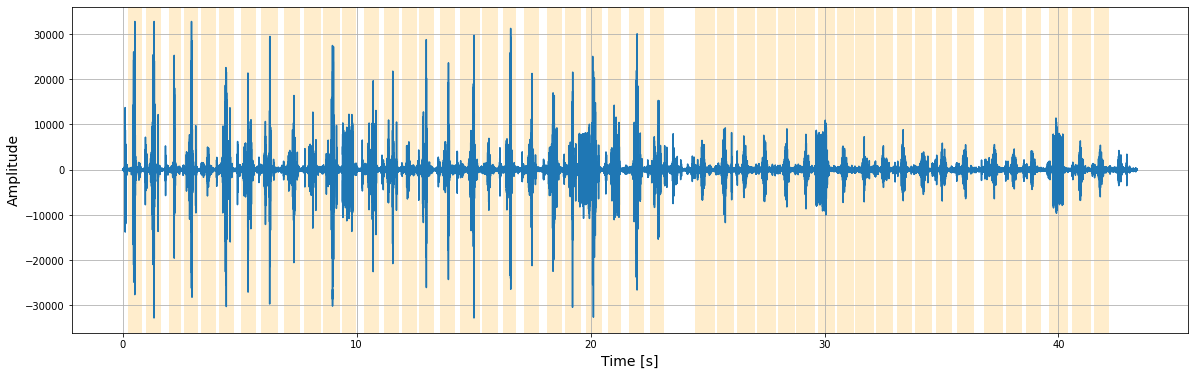

In [82]:
fig, ax = plt.subplots(1, 1, figsize=(20,6))
ax.plot(t, data)
ax.grid(True)
ax.set_xlabel('Time [s]', fontsize=14)
ax.set_ylabel('Amplitude', fontsize=14)
for idx in range(len(data_labels)):
        plt.axvspan(data_labels['start'].iloc[idx], data_labels['end'].iloc[idx], color='orange', alpha=0.2, lw=0)

### Normalizacion


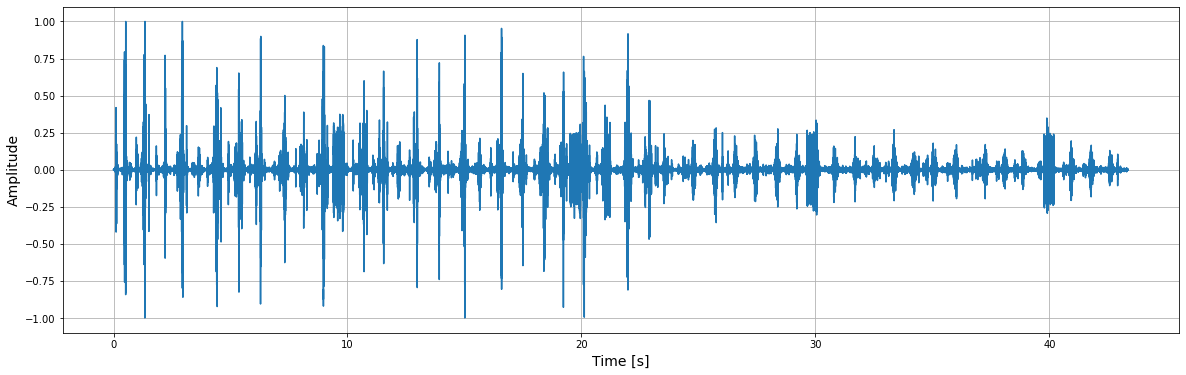

In [83]:
data = (data - data.min())
data = data / (data.max() - data.min())
data = 2*(data - data.mean())

fig, ax = plt.subplots(1, 1, figsize=(20,6))
ax.plot(t, data)
ax.grid(True)
ax.set_xlabel('Time [s]', fontsize=14)
ax.set_ylabel('Amplitude', fontsize=14);

### Filtro a 4000 Hz

Frecuencia de Nyquist: 11025.0 Hz
Orden: 20
Banda de paso (especificada [normalizada]) --> wp: 2000
Banda de paso (calculada)                  --> wn: 0.1814262868141029 (2000.2248121254843)
Numerador: [5.36560934e-13 1.07312187e-11 1.01946577e-10 6.11679465e-10
 2.59963772e-09 8.31884072e-09 2.07971018e-08 4.15942036e-08
 6.75905808e-08 9.01207744e-08 9.91328519e-08 9.01207744e-08
 6.75905808e-08 4.15942036e-08 2.07971018e-08 8.31884072e-09
 2.59963772e-09 6.11679465e-10 1.01946577e-10 1.07312187e-11
 5.36560934e-13]

Denominador: [ 1.00000000e+00 -1.27370049e+01  7.79890433e+01 -3.04958966e+02
  8.53426254e+02 -1.81568444e+03  3.04536097e+03 -4.12131260e+03
  4.56838435e+03 -4.18697973e+03  3.18900280e+03 -2.02132589e+03
  1.06401610e+03 -4.62484062e+02  1.64325411e+02 -4.69820558e+01
  1.05530913e+01 -1.79443059e+00  2.17251900e-01 -1.66955214e-02
  6.12387647e-04]
Señal filtrada: [-1.76291754e-15 -5.97048013e-14 -9.99778186e-13 ...  1.48736247e-03
  1.54517122e-03  1.59421846e-03]


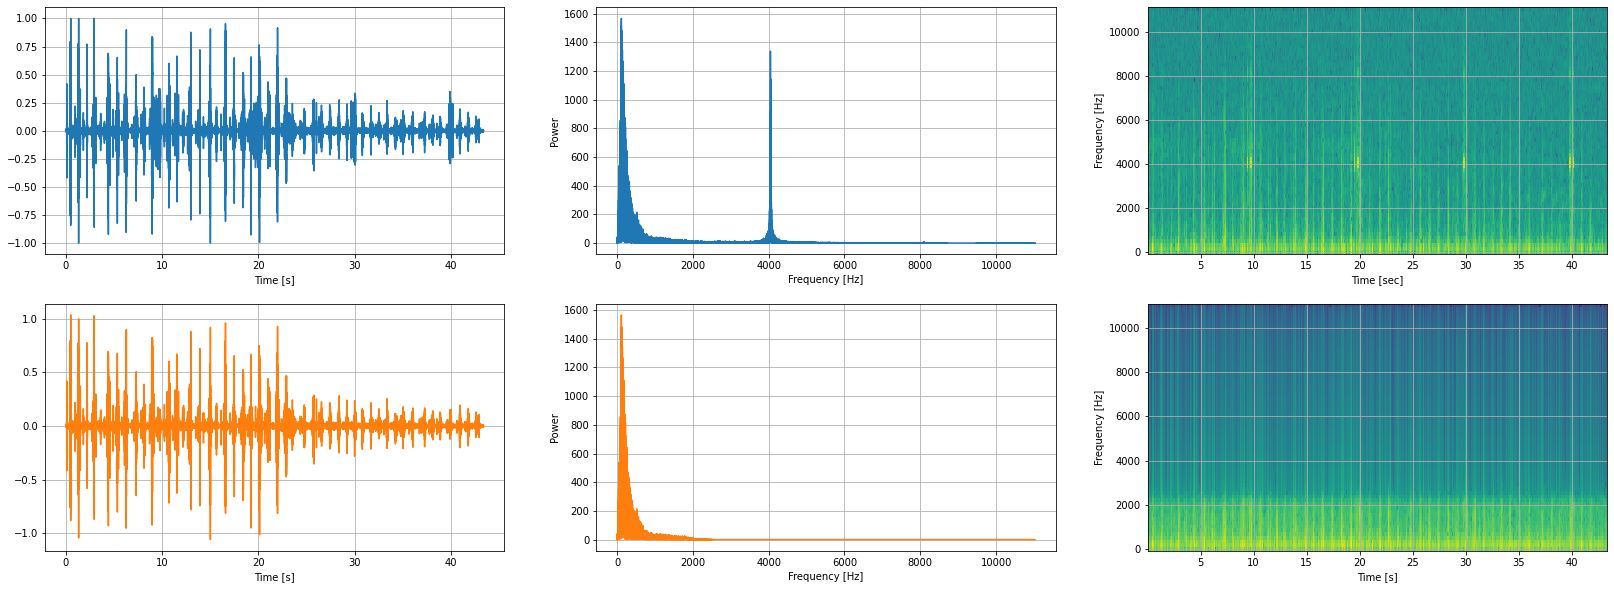

In [84]:
from scipy import fftpack

f_nyq = fs/2  # Frecuencia Nyquist

print(f'Frecuencia de Nyquist: {f_nyq} Hz')

# Busco el orden del filtro de acuerdo a las especificaciones

wp = 2000

order, wn = scipy.signal.buttord(wp=2000,       # Banda de paso [Hz]
                                 ws=2500,       # Banda de rechazo [Hz]
                                 gpass=3,       # Atenuación de 3 dB en banda de paso
                                 gstop=40,      # Atenuación de 60 dB en banda de stop
                                 analog=False,  # Digital
                                 fs=fs)         # [Hz]

print('Orden: {}'.format(order))
print('Banda de paso (especificada [normalizada]) --> wp: {}'.format(wp))
print('Banda de paso (calculada)                  --> wn: {} ({})'.format(wn/f_nyq, wn))

# DISEÑO EL FILTRO
b, a = scipy.signal.butter(order,
                           wn,
                           btype='lowpass',
                           analog=False,
                           fs=fs)

b

# FILTRO LA SEÑAL
data_filt_2K = scipy.signal.lfilter(b, a, data)  # Aplico el filtro a la señal

print(f'Numerador: {b}\n\nDenominador: {a}')

print(f'Señal filtrada: {data_filt_2K}')

# GRAFICO LOS RESULTADOS

fig, ax = plt.subplots(2, 3, figsize=(28,10))

ax[0,0].plot(t, data, '-C0');
ax[0,0].grid(True)
ax[0,0].set_xlabel('Time [s]')

#----------------------------------------

#La función scipy.fftpack.fftfreq() genera las frecuencias de muestreo
sample_freq = fftpack.fftfreq(data.size, d=1/fs)

# scipy.fftpack.fft() calcula la transformada rápida de Fourier
sig_fft = fftpack.fft(data)

# Debido a que la potencia resultante es simétrica, sólo la parte positiva
# del espectro es utilizada para encontrar la frecuencia

idxs = np.where(sample_freq >= 0)

freqs = sample_freq[idxs]

power = np.abs(sig_fft)[idxs]

ax[0,1].plot(freqs, power, '-C0')
ax[0,1].set_xlabel('Frequency [Hz]')
ax[0,1].set_ylabel('Power')
ax[0,1].grid(True)

#----------------------------------------

f, t1, Sxx = scipy.signal.spectrogram(data,
                                      fs,
                                      window='hanning',
                                      noverlap=65, # Number of points to overlap between segments
                                      nperseg=130,  # Length of each segment
                                      scaling='spectrum')

ax[0,2].pcolormesh(t1, f, 10*np.log10(Sxx), shading='auto')
ax[0,2].set_ylabel('Frequency [Hz]')
ax[0,2].set_xlabel('Time [sec]')
ax[0,2].grid(True)

#----------------------------------------

ax[1,0].plot(t, data_filt_2K, '-C1');
ax[1,0].grid(True)
ax[1,0].set_xlabel('Time [s]')

#----------------------------------------

#La función scipy.fftpack.fftfreq() genera las frecuencias de muestreo
sample_freq = fftpack.fftfreq(data_filt_2K.size, d=1/fs)

# scipy.fftpack.fft() calcula la transformada rápida de Fourier
sig_fft = fftpack.fft(data_filt_2K)

# Debido a que la potencia resultante es simétrica, sólo la parte positiva
# del espectro es utilizada para encontrar la frecuencia

idxs = np.where(sample_freq >= 0)

freqs = sample_freq[idxs]

power = np.abs(sig_fft)[idxs]

ax[1,1].plot(freqs, power, '-C1')
ax[1,1].set_xlabel('Frequency [Hz]')
ax[1,1].set_ylabel('Power')
ax[1,1].grid(True)

#----------------------------------------

f, t1, Sxx = scipy.signal.spectrogram(data_filt_2K,
                                      fs,
                                      window='hanning',
                                      noverlap=65, # Number of points to overlap between segments
                                      nperseg=130,  # Length of each segment
                                      scaling='spectrum')

ax[1,2].pcolormesh(t1, f, 10*np.log10(Sxx), shading='auto')
ax[1,2].set_ylabel('Frequency [Hz]')
ax[1,2].set_xlabel('Time [s]')
ax[1,2].grid(True)

plt.tight_layout;

# Guardo el archivo de audio

#scaled = np.int16(data_filt_2K/np.max(np.abs(data_filt_2K)) * 32767)
#scipy.io.wavfile.write(filename.replace('.wav','_filterd.wav'), fs, scaled)

### Filtro para deteccion de eventos

Orden: 4
Banda de paso (especificada [normalizada]) --> wp: 5
Banda de paso (calculada)                  --> wn: 0.00045378403353931113 (5.002968969770905)


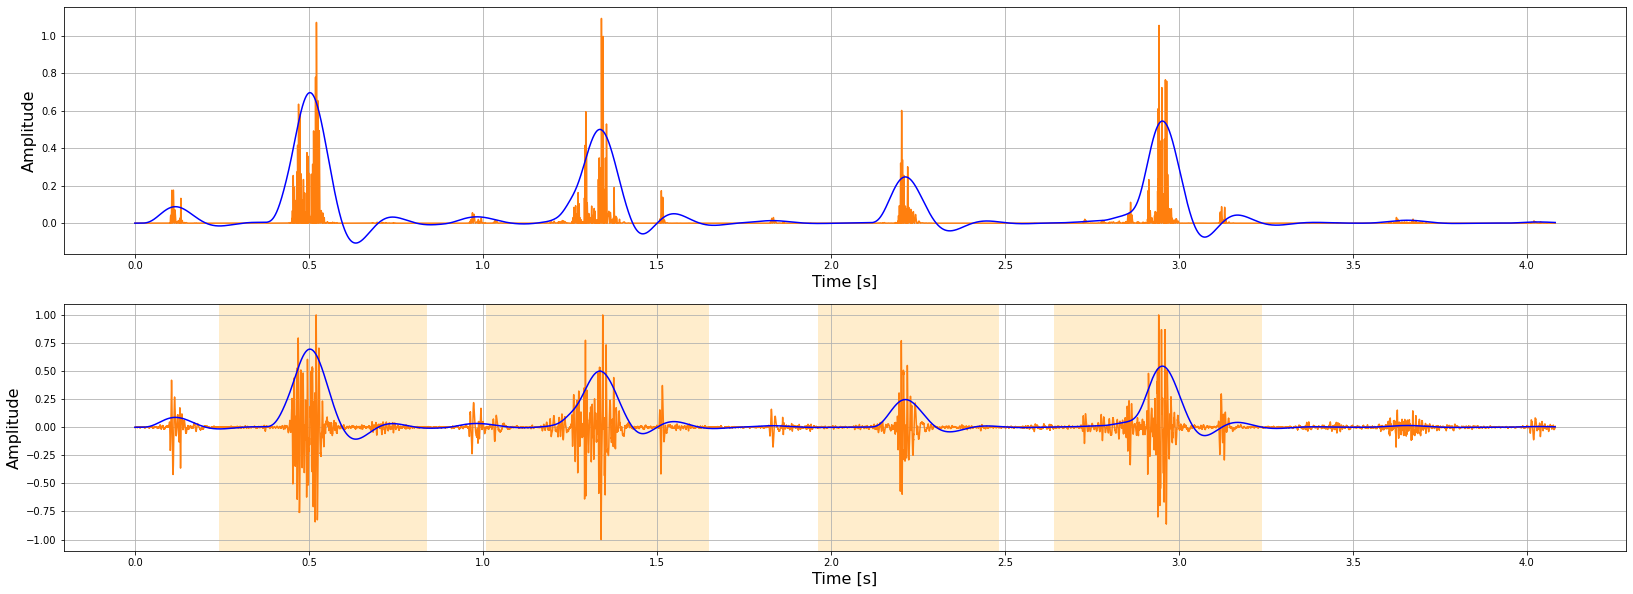

In [85]:
# Busco el orden del filtro de acuerdo a las especificaciones

wp = 5

order, wn = scipy.signal.buttord(wp=wp,          # Banda de paso [Hz]
                                 ws=20,         # Banda de rechazo [Hz]
                                 gpass=3,       # Atenuación de 3 dB en banda de paso
                                 gstop=40,      # Atenuación de 40 dB en banda de stop
                                 analog=False,  # Digital
                                 fs=fs)         # [Hz]

print('Orden: {}'.format(order))
print('Banda de paso (especificada [normalizada]) --> wp: {}'.format(wp))
print('Banda de paso (calculada)                  --> wn: {} ({})'.format(wn/f_nyq, wn))

# DISEÑO EL FILTRO
b, a = scipy.signal.butter(order,
                           wn,
                           btype='lowpass',
                           analog=False,
                           fs=fs)

X = np.float32(data_filt_2K)**2
#X = np.abs(data_filt_2K)

# FILTRO LA SEÑAL
data_filt_5 = scipy.signal.lfilter(b, a, X)  # Aplico el filtro a la señal
#data_filt_5 = scipy.signal.filtfilt(b, a, X)  # Aplico el filtro a la señal

data_filt_5

n = 90000
m = 2000

fig, ax = plt.subplots(2, 1, figsize=(28,10))

ax[0].plot(t[:n], X[:n], '-C1')
ax[0].plot(t[:n], 6*(data_filt_5)[m:n+m], '-b')
ax[0].set_xlabel('Time [s]', fontsize=16)
ax[0].set_ylabel('Amplitude', fontsize=16)
ax[0].grid(True)

ax[1].plot(t[:n], data[:n], '-C1')
ax[1].plot(t[:n], 6*(data_filt_5)[m:n+m], '-b')
for idx in range(0,4):
        ax[1].axvspan(data_labels['start'].iloc[idx], data_labels['end'].iloc[idx], color='orange', alpha=0.2, lw=0)
ax[1].set_xlabel('Time [s]', fontsize=16)
ax[1].set_ylabel('Amplitude', fontsize=16)
ax[1].grid(True)

### Feature Extraction

In [86]:
data_filt = 6*(data_filt_5)

In [87]:
time_mean = np.mean(data_labels.end - data_labels.start)
time_std = np.std(data_labels.end - data_labels.start)


In [88]:
time_mean

0.687750085106383

In [89]:
time_std

0.07535691380607162

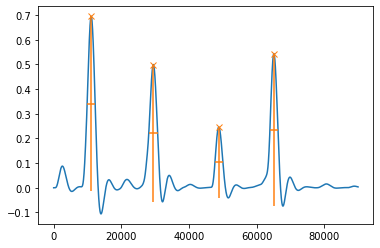

In [90]:
from scipy.signal import find_peaks

data_plot = 6*(data_filt_5)[m:n+m]
peaks, properties = find_peaks(data_plot, prominence=0.1, width=20)


plt.plot(6*(data_filt_5)[m:n+m])
plt.plot(peaks, data_plot[peaks], "x")
plt.vlines(x=peaks, ymin=data_plot[peaks] - properties["prominences"],
           ymax = data_plot[peaks], color = "C1")
plt.hlines(y=properties["width_heights"], xmin=properties["left_ips"],
           xmax=properties["right_ips"], color = "C1")
plt.show()

In [91]:
peaks, properties = find_peaks(data_filt, distance = 15000, prominence=0.01, width=2000)

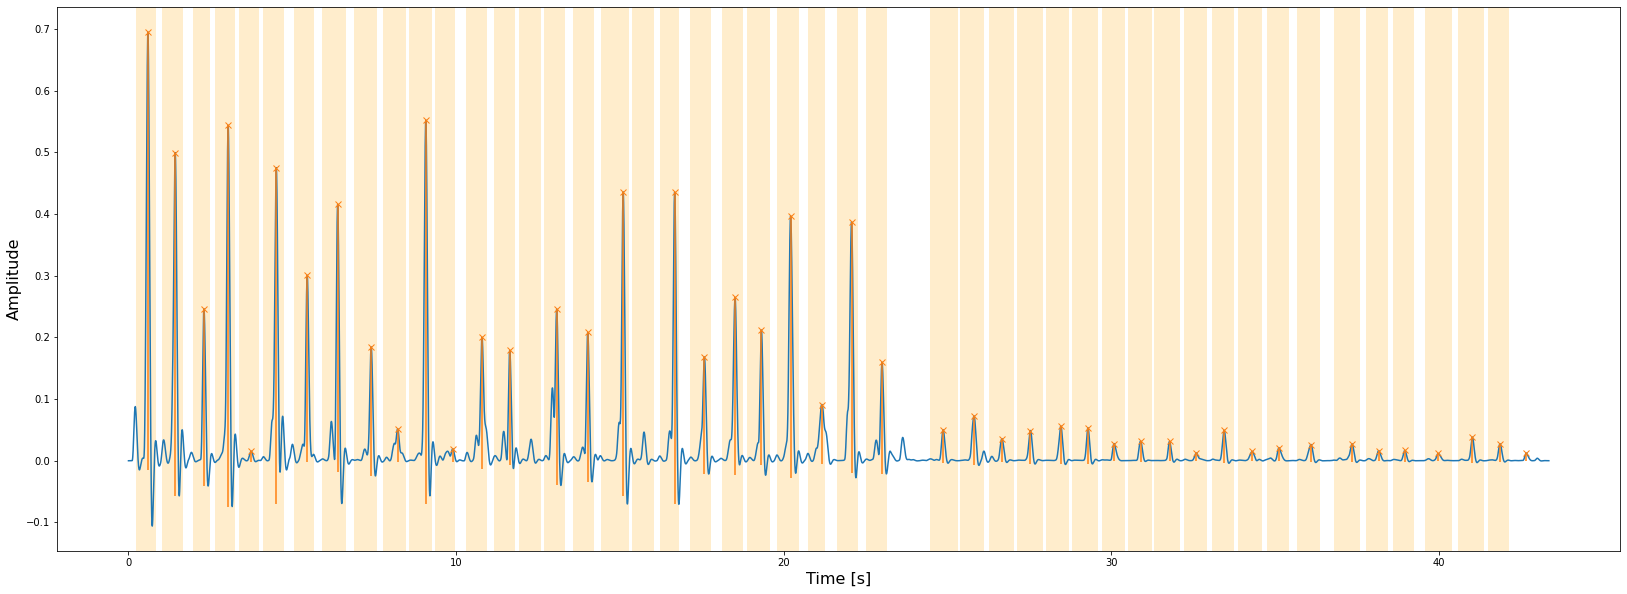

In [92]:
peaks_time = peaks/len(t) * (Ts*N)

plt.figure(figsize=(28,10))
plt.plot(t, data_filt)
for idx in range(len(data_labels)):
        plt.axvspan(data_labels['start'].iloc[idx], data_labels['end'].iloc[idx], color='orange', alpha=0.2, lw=0)

plt.plot(peaks_time, data_filt[peaks], "x")
plt.vlines(x=peaks_time, ymin=data_filt[peaks] - properties["prominences"],
           ymax = data_filt[peaks], color = "C1")
#plt.hlines(y=properties["width_heights"], xmin=properties["left_ips"],
#           xmax=properties["right_ips"], color = "C1")
plt.xlabel('Time [s]', fontsize=16)
plt.ylabel('Amplitude', fontsize=16)


plt.show()

### Generate windows

In [93]:
audio_list = []
peaks_time = peaks/len(t) * (Ts*N)
for peak in peaks_time:
    start = peak - time_mean/2 - time_std
    end = peak + time_mean/2 - time_std
    audio_list.append((start, end))
    


In [94]:
audio_list

[(0.17464559466114504, 0.8623956797675281),
 (1.0078882250466326, 1.6956383101530157),
 (1.8856206513504872, 2.5733707364568703),
 (2.6242147556588775, 3.31196484076526),
 (3.328387091259785, 4.0161371763661675),
 (4.094509540239375, 4.782259625345759),
 (5.0386818758402825, 5.726431960946666),
 (5.968114982416246, 6.65586506752263),
 (6.992241966543231, 7.679992051649615),
 (7.800269177427584, 8.488019262533967),
 (8.659044687631667, 9.34679477273805),
 (9.481811127540963, 10.169561212647347),
 (10.375643327087447, 11.06339341219383),
 (11.222491399649806, 11.91024148475619),
 (12.656006138878832, 13.343756223985215),
 (13.60412405271103, 14.291874137817414),
 (14.686074166089716, 15.3738242511961),
 (16.25709457425298, 16.94484465935936),
 (17.166346274933254, 17.854096360039634),
 (18.10172042459312, 18.7894705096995),
 (18.90657303230287, 19.59432311740925),
 (19.79750273751829, 20.48525282262467),
 (20.751516342960468, 21.439266428066848),
 (21.65804695520536, 22.34579704031174),


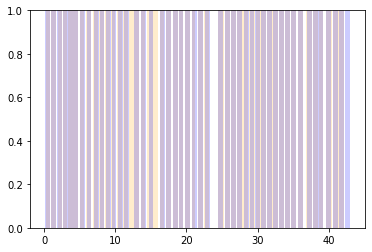

In [95]:
for idx in range(len(data_labels)):
        plt.axvspan(data_labels['start'].iloc[idx], data_labels['end'].iloc[idx], color='orange', alpha=0.2, lw=0)
for idx in range(len(audio_list)):
        plt.axvspan(audio_list[idx][0], audio_list[idx][1], color='blue', alpha=0.2, lw=0)


### Metricas

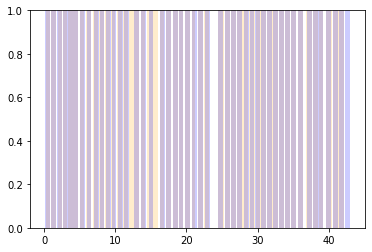

In [96]:
y_hat = t.copy()
y = t.copy()
for idx in range(len(data_labels)):
        plt.axvspan(data_labels['start'].iloc[idx], data_labels['end'].iloc[idx], color='orange', alpha=0.2, lw=0)
        start = data_labels['start'].iloc[idx] 
        end =  data_labels['end'].iloc[idx]
        
        index = np.where((y<end) & (y>=start))
        y[index] = 1
        
index_none = np.where(y!= 1)
y[index_none] = 0


for idx in range(len(audio_list)):
        plt.axvspan(audio_list[idx][0], audio_list[idx][1], color='blue', alpha=0.2, lw=0)
        start = audio_list[idx][0]
        end =  audio_list[idx][1]
        
        index = np.where((y_hat<end) & (y_hat>=start))
        y_hat[index] = 1
        
index_none = np.where(y_hat!= 1)
y_hat[index_none] = 0

In [97]:
intersection = np.minimum(y, y_hat)
union = y + y_hat
union[np.where(union > 1)] = 1

inter = np.sum(intersection * t)
union = np.sum(union * t)


ratio = np.round(inter/union, 2) * 100
print('IoU: ',ratio)

IoU:  81.0


In [98]:
len(audio_list)/len(data_labels)

0.9787234042553191

In [117]:
from scipy.signal import peak_widths
widths = peak_widths(data_plot, peaks)
width = np.mean(widths[0])

In [118]:
width

2227.6307989809793